### Import Important Packages

In [1]:
import geopandas as gpd
from shapely.geometry import box,Polygon
import matplotlib.pyplot as plt
import numpy as np
import math
from illuminating.data_preparation.geodata_processing import download_gdf,create_grids
import seaborn as sns
%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'illuminating'

In [74]:
!pip install scikit-learn

In [4]:
import sqlite3
def get_uspvdb(state:str="CA"):
    # Load the CSV file into a Pandas DataFrame
    csv_file_path = 'uspvdb_v2_0_20240801.csv'
    df = pd.read_csv(csv_file_path)
    # Create an in-memory SQLite database
    conn = sqlite3.connect(':memory:')
    # Write the DataFrame to the SQLite database
    df.to_sql('power_plants', conn, index=False, if_exists='replace')
    # Query
    query = f"SELECT ylat, xlong, p_area,p_year,p_cap_dc FROM power_plants WHERE p_state = '{state}'"
    result_df = pd.read_sql_query(query, conn)
    return result_df

### Distance to the Nearest Population

#### Import Base Map for California

In [5]:
USA_gdf=download_gdf("USA",1)
USA_gdf.head()

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,USA.1_1,USA,UnitedStates,Alabama,AL|Ala.,NA,State,State,NA,US.AL,US-AL,"MULTIPOLYGON (((-88.12060 30.23320, -88.12330 ..."
1,USA.2_1,USA,UnitedStates,Alaska,AK|Alaska,NA,State,State,NA,US.AK,US-AK,"MULTIPOLYGON (((-179.13150 51.20970, -179.1328..."
2,USA.3_1,USA,UnitedStates,Arizona,AZ|Ariz.,NA,State,State,NA,US.AZ,US-AZ,"MULTIPOLYGON (((-110.75620 31.33290, -111.0750..."
3,USA.4_1,USA,UnitedStates,Arkansas,AR|Ark.,NA,State,State,NA,US.AR,US-AR,"MULTIPOLYGON (((-91.90710 33.00800, -92.86190 ..."
4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,"MULTIPOLYGON (((-117.23300 32.77420, -117.2336..."


In [6]:
california_gdf = USA_gdf[USA_gdf.NAME_1== "California"]
california_gdf

,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,"MULTIPOLYGON (((-117.23300 32.77420, -117.2336..."


<Axes: >

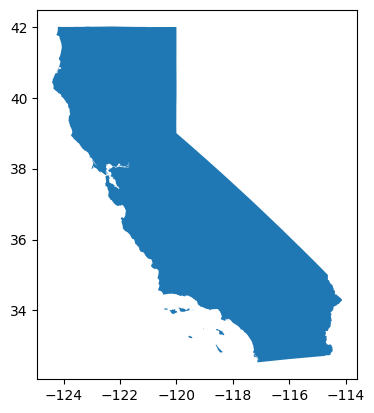

In [7]:
california_gdf.plot()

In [40]:
california_crs = california_gdf.crs
california_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Importing Population Data

In [41]:
pop_gdf = gpd.read_file("california_pop.geojson").set_crs(california_crs)
pop_gdf.head()

,X,Y,Z,id,index_right,GID_1,GID_0,COUNTRY,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,ISO_1,geometry
0,-123.205416,42.00375,0.0,8193207,4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,POINT (-123.20542 42.00375)
1,-123.197083,42.00375,0.0,8193208,4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,POINT (-123.19708 42.00375)
2,-123.188749,42.00375,0.0,8193209,4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,POINT (-123.18875 42.00375)
3,-123.180416,42.00375,0.0,8193210,4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,POINT (-123.18042 42.00375)
4,-123.172083,42.00375,0.0,8193211,4,USA.5_1,USA,UnitedStates,California,CA|Calif.,NA,State,State,NA,US.CA,US-CA,POINT (-123.17208 42.00375)


In [42]:
pop_gdf = pop_gdf[["X","Y","Z","geometry"]]

In [43]:
pop_gdf.columns = ["long","lat","population","geometry"]
pop_gdf.head()

,long,lat,population,geometry
0,-123.205416,42.00375,0.0,POINT (-123.20542 42.00375)
1,-123.197083,42.00375,0.0,POINT (-123.19708 42.00375)
2,-123.188749,42.00375,0.0,POINT (-123.18875 42.00375)
3,-123.180416,42.00375,0.0,POINT (-123.18042 42.00375)
4,-123.172083,42.00375,0.0,POINT (-123.17208 42.00375)


In [44]:
pop_gdf["population"].describe()

count    595741.000000
mean         68.393535
std         405.687154
min           0.000000
25%           0.000000
50%           0.003398
75%           0.764128
max       29433.517578
Name: population, dtype: float64

In [45]:
pop_gdf["population"].sum()

np.float64(40744832.677218415)

In [46]:
pop_gdf[pop_gdf.population > 10]["population"].describe()

count    70251.000000
mean       575.928599
std       1050.549193
min         10.000398
25%         22.652754
50%         74.279945
75%        680.475250
max      29433.517578
Name: population, dtype: float64

In [47]:
first_q =math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.25]).iloc[0])
sec_q = math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.5]).iloc[0])
third_q = math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.75]).iloc[0])
first_q,sec_q,third_q

(22, 74, 680)

#### Preprocessing the Population Data by Categorizing based on Population Size

In [48]:
def check_pop(pop,first_q,sec_q,third_q):
    if pop>first_q and pop<sec_q:
        return 10
    elif pop>sec_q and pop<third_q:
        return 50
    elif pop>third_q:
        return 100
    return 0

def categorize_pop(pop_gdf):
    first_q =math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.25]).iloc[0])
    sec_q = math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.5]).iloc[0])
    third_q = math.floor(pop_gdf[pop_gdf.population > 10]["population"].quantile([0.75]).iloc[0])
    pop_gdf["population_size"] = pop_gdf["population"].apply(check_pop,args=[first_q,sec_q,third_q])
    return pop_gdf


In [49]:
categorize_pop(pop_gdf).head(10)

,long,lat,population,geometry,population_size
0,-123.205416,42.00375,0.000000,POINT (-123.20542 42.00375),0
1,-123.197083,42.00375,0.000000,POINT (-123.19708 42.00375),0
2,-123.188749,42.00375,0.000000,POINT (-123.18875 42.00375),0
3,-123.180416,42.00375,0.000000,POINT (-123.18042 42.00375),0
4,-123.172083,42.00375,0.000000,POINT (-123.17208 42.00375),0
5,-123.163749,42.00375,0.000000,POINT (-123.16375 42.00375),0
6,-123.155416,42.00375,0.000000,POINT (-123.15542 42.00375),0
7,-123.147083,42.00375,0.000000,POINT (-123.14708 42.00375),0
8,-123.138749,42.00375,2.212726,POINT (-123.13875 42.00375),0
9,-123.130416,42.00375,1.504882,POINT (-123.13042 42.00375),0


#### Plotting the Population Size on the California Map

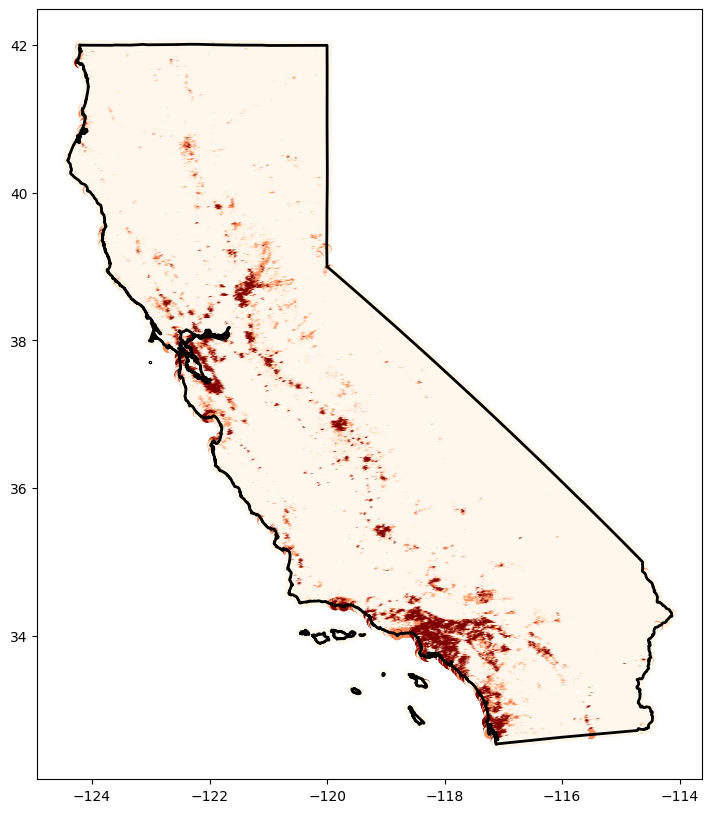

In [202]:
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
pop_gdf.plot(ax=ax,column="population_size",cmap='OrRd')
plt.show();

#### Creating new Dataframe for Population Bigger than Small

In [51]:
pop_more_than_small = pop_gdf[pop_gdf.population_size>0]
pop_more_than_small.head()

,long,lat,population,geometry,population_size
136,-124.205416,41.995417,48.063469,POINT (-124.20542 41.99542),10
405,-121.963749,41.995417,28.579935,POINT (-121.96375 41.99542),10
454,-121.555416,41.995417,28.864395,POINT (-121.55542 41.99542),10
515,-124.205416,41.987083,22.657887,POINT (-124.20542 41.98708),10
965,-120.297083,41.987083,23.718102,POINT (-120.29708 41.98708),10


In [54]:
pop_more_than_small.shape[0], pop_gdf.shape[0]

(53238, 595741)

#### Creating new Dataframe for Population Bigger than Medium

In [111]:
pop_more_than_medium = pop_gdf[pop_gdf.population_size>=50]
pop_more_than_medium.head()

,long,lat,population,geometry,population_size
1760,-121.922083,41.970417,307.560272,POINT (-121.92208 41.97042),50
1761,-121.913749,41.970417,258.701630,POINT (-121.91375 41.97042),50
2245,-121.922083,41.962083,370.166168,POINT (-121.92208 41.96208),50
2298,-121.480416,41.962083,198.877899,POINT (-121.48042 41.96208),50
2457,-124.205416,41.953750,138.955170,POINT (-124.20542 41.95375),50


#### Creating new Dataframe for Population Bigger than Large

In [112]:
pop_more_than_large = pop_gdf[pop_gdf.population_size==100]
pop_more_than_large.head()

,long,lat,population,geometry,population_size
8201,-124.155416,41.853750,1460.570190,POINT (-124.15542 41.85375),100
8202,-124.147083,41.853750,1933.029297,POINT (-124.14708 41.85375),100
12631,-124.197083,41.778750,734.023621,POINT (-124.19708 41.77875),100
13129,-124.213749,41.770417,711.610168,POINT (-124.21375 41.77042),100
13131,-124.197083,41.770417,930.593445,POINT (-124.19708 41.77042),100


#### Importing the Power Plant Location Data + Location Where there is none for Training

In [55]:
import pandas as pd
cali_pp_df = pd.read_csv("CA_locations_2000.csv")
cali_pp_df.head(), cali_pp_df.describe()

(   Unnamed: 0   Longitude   Latitude  have_plant
 0           0 -120.109391  36.177598           1
 1           1 -116.327979  33.265240           1
 2           2 -118.304671  34.707428           1
 3           3 -118.274109  34.708588           1
 4           4 -120.115552  36.175836           1,
         Unnamed: 0    Longitude     Latitude   have_plant
 count  2315.000000  2315.000000  2315.000000  2315.000000
 mean   1157.000000  -119.465454    36.979305     0.233261
 std     668.427259     2.428801     2.567160     0.422999
 min       0.000000  -124.274756    32.587901     0.000000
 25%     578.500000  -121.382315    34.826099     0.000000
 50%    1157.000000  -119.731053    36.505254     0.000000
 75%    1735.500000  -117.576541    39.139163     0.000000
 max    2314.000000  -114.391503    41.999371     1.000000)

In [59]:
no_of_plants = cali_pp_df.have_plant.sum()
print(f"Numbers of location with plant: {no_of_plants}")

Numbers of location with plant: 540


In [62]:
no_of_row = cali_pp_df.shape[0]
print(f"Numbers of location without plant: {no_of_row - no_of_plants}")
print(f"Ratio of location with plants: {round(no_of_plants/no_of_row,2)}")

Numbers of location without plant: 1775
Ratio of location with plants: 0.23


In [87]:
base_metric = round(1-no_of_plants/no_of_row,2)
print(f"Base metric for classification:{base_metric}")

Base metric for classification:0.77


Convert to geodataframe

In [65]:
cali_pp_gdf = gpd.GeoDataFrame(cali_pp_df,
                               geometry =gpd.points_from_xy(cali_pp_df.Longitude, cali_pp_df.Latitude),
                               crs = california_crs)
cali_pp_gdf.head(10)

,Unnamed: 0,Longitude,Latitude,have_plant,geometry
0,0,-120.109391,36.177598,1,POINT (-120.10939 36.17760)
1,1,-116.327979,33.265240,1,POINT (-116.32798 33.26524)
2,2,-118.304671,34.707428,1,POINT (-118.30467 34.70743)
3,3,-118.274109,34.708588,1,POINT (-118.27411 34.70859)
4,4,-120.115552,36.175836,1,POINT (-120.11555 36.17584)
5,5,-118.242989,34.903488,1,POINT (-118.24299 34.90349)
6,6,-120.046435,36.941045,1,POINT (-120.04644 36.94105)
7,7,-115.532695,32.967109,1,POINT (-115.53270 32.96711)
8,8,-119.110889,35.801176,1,POINT (-119.11089 35.80118)
9,9,-118.288133,34.665582,1,POINT (-118.28813 34.66558)


In [66]:
cali_pp_gdf.columns

Index(['Unnamed: 0', 'Longitude', 'Latitude', 'have_plant', 'geometry'], dtype='object')

In [68]:
cali_pp_gdf.drop(columns =['Unnamed: 0'],inplace=True)

#### Combining with Population Data and measure the Distances

##### Combining with Any Population center dataset and measure the Distances

In [110]:
cali_pp_with_pop = gpd.sjoin_nearest(cali_pp_gdf.to_crs(epsg=32733),pop_more_than_small.to_crs(epsg=32733),distance_col="distance_to_anypop").to_crs(california_crs)
cali_pp_with_pop["distance_to_anypop"] = cali_pp_with_pop["distance_to_anypop"]/1000
cali_pp_with_pop.head()

,Longitude,Latitude,have_plant,geometry,index_right,long,lat,population,population_size,distance_to_anypop
0,-120.109391,36.177598,1,POINT (-120.10939 36.17760),355220,-120.105416,36.195417,1429.091431,100,2.444943
1,-116.327979,33.265240,1,POINT (-116.32798 33.26524),571656,-116.355416,33.262083,96.502167,50,3.315774
2,-118.304671,34.707428,1,POINT (-118.30467 34.70743),480305,-118.288750,34.703750,72.197060,10,1.890666
3,-118.274109,34.708588,1,POINT (-118.27411 34.70859),480305,-118.288750,34.703750,72.197060,10,1.803578
4,-120.115552,36.175836,1,POINT (-120.11555 36.17584),355219,-120.113750,36.195417,30.632030,10,2.651035


##### Combining with Medium or Higher Population center dataset and measure the Distances

In [116]:
cali_pp_with_med_pop = gpd.sjoin_nearest(cali_pp_gdf.to_crs(epsg=32733),pop_more_than_medium.to_crs(epsg=32733),distance_col="distance_to_medpop").to_crs(california_crs)
cali_pp_with_med_pop["distance_to_medpop"] = cali_pp_with_med_pop["distance_to_medpop"]/1000
cali_pp_with_med_pop.head()

,Longitude,Latitude,have_plant,geometry,index_right,long,lat,population,population_size,distance_to_medpop
0,-120.109391,36.177598,1,POINT (-120.10939 36.17760),355220,-120.105416,36.195417,1429.091431,100,2.444943
1,-116.327979,33.265240,1,POINT (-116.32798 33.26524),571656,-116.355416,33.262083,96.502167,50,3.315774
2,-118.304671,34.707428,1,POINT (-118.30467 34.70743),476633,-118.297083,34.745417,113.979179,50,5.330712
3,-118.274109,34.708588,1,POINT (-118.27411 34.70859),480311,-118.238750,34.703750,475.783569,50,4.100286
4,-120.115552,36.175836,1,POINT (-120.11555 36.17584),355220,-120.105416,36.195417,1429.091431,100,2.867113


In [133]:
cali_pp_with_med_pop[cali_pp_with_med_pop.have_plant == 1]["population"].describe()

count     540.000000
mean      413.003802
std       580.730681
min        74.098694
25%        98.952465
50%       164.891716
75%       450.744408
max      5191.172363
Name: population, dtype: float64

##### Combining with Large Population center dataset and measure the Distances

In [118]:
cali_pp_with_large_pop = gpd.sjoin_nearest(cali_pp_gdf.to_crs(epsg=32733),pop_more_than_large.to_crs(epsg=32733),distance_col="distance_to_largepop").to_crs(california_crs)
cali_pp_with_large_pop["distance_to_largepop"] = cali_pp_with_large_pop["distance_to_largepop"]/1000
cali_pp_with_large_pop.head()

,Longitude,Latitude,have_plant,geometry,index_right,long,lat,population,population_size,distance_to_largepop
0,-120.109391,36.177598,1,POINT (-120.10939 36.17760),355220,-120.105416,36.195417,1429.091431,100,2.444943
1,-116.327979,33.265240,1,POINT (-116.32798 33.26524),566276,-116.038750,33.403750,804.123535,100,39.878802
2,-118.304671,34.707428,1,POINT (-118.30467 34.70743),481784,-118.238750,34.687083,1101.177612,100,8.050977
3,-118.274109,34.708588,1,POINT (-118.27411 34.70859),481784,-118.238750,34.687083,1101.177612,100,5.024315
4,-120.115552,36.175836,1,POINT (-120.11555 36.17584),355220,-120.105416,36.195417,1429.091431,100,2.867113


#### Try the Classification Model

##### For Distance to Any Population

In [138]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_validate

In [101]:
X = cali_pp_with_pop[["distance_to_pop"]]

In [102]:
y = cali_pp_with_pop["have_plant"]

In [103]:
log_model = LogisticRegression(random_state=0)

In [104]:
log_model_score = cross_validate(log_model,X,y,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
log_score_df = pd.DataFrame(log_model_score)
log_score_df

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.037660,0.029269,0.766739,0.148148,0.500000,0.228571
1,0.013250,0.015211,0.762419,0.333333,0.486486,0.395604
2,0.010329,0.013814,0.766739,0.231481,0.500000,0.316456
3,0.011553,0.011294,0.781857,0.259259,0.571429,0.356688
4,0.011424,0.010715,0.738661,0.166667,0.367347,0.229299


In [106]:
log_score_df["test_accuracy"].mean()

np.float64(0.7632829373650108)

In [107]:
from sklearn.neighbors import KNeighborsClassifier
KNN_results = cross_validate(KNeighborsClassifier(),X,y,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
KNN_results_df = pd.DataFrame(KNN_results)
KNN_results_df

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.017571,0.056860,0.745140,0.370370,0.444444,0.404040
1,0.003527,0.032413,0.764579,0.351852,0.493506,0.410811
2,0.002504,0.029498,0.760259,0.333333,0.480000,0.393443
3,0.004135,0.031691,0.771058,0.416667,0.511364,0.459184
4,0.003858,0.031125,0.747300,0.351852,0.447059,0.393782


In [108]:
KNN_results_df["test_recall"].mean()

np.float64(0.3648148148148148)

##### For Distance to Medium or Larger Population

In [134]:
X_med = cali_pp_with_med_pop[["distance_to_medpop"]]
X_med

,distance_to_medpop
0,2.444943
1,3.315774
2,5.330712
3,4.100286
4,2.867113
...,...
2310,9.565304
2311,1.627631
2312,29.895305
2313,20.348009


In [135]:
y_med = cali_pp_with_med_pop["have_plant"]
y_med

0       1
1       1
2       1
3       1
4       1
       ..
2310    0
2311    0
2312    0
2313    0
2314    0
Name: have_plant, Length: 2315, dtype: int64

In [139]:
log_model_med = LogisticRegression()

In [140]:
log_model_med_score = cross_validate(log_model_med,X_med,y_med,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
log_score_med_df = pd.DataFrame(log_model_med_score)
log_score_med_df

/home/kalimdorfolk/.pyenv/versions/3.10.6/envs/illuminating_horizons/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kalimdorfolk/.pyenv/versions/3.10.6/envs/illuminating_horizons/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kalimdorfolk/.pyenv/versions/3.10.6/envs/illuminating_horizons/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` paramete

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.014279,0.016616,0.766739,0.000000,0.000000,0.000000
1,0.010523,0.011212,0.747300,0.129630,0.378378,0.193103
2,0.012470,0.011846,0.766739,0.000000,0.000000,0.000000
3,0.008234,0.009931,0.766739,0.000000,0.000000,0.000000
4,0.009168,0.009754,0.768898,0.194444,0.512195,0.281879


In [106]:
log_score_df["test_accuracy"].mean()

np.float64(0.7632829373650108)

In [141]:
from sklearn.neighbors import KNeighborsClassifier
KNN_results_med = cross_validate(KNeighborsClassifier(),X_med,y_med,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
KNN_results_med_df = pd.DataFrame(KNN_results_med)
KNN_results_med_df

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.017865,0.034926,0.742981,0.296296,0.426667,0.349727
1,0.002947,0.056306,0.740821,0.342593,0.430233,0.381443
2,0.003582,0.031245,0.740821,0.361111,0.433333,0.393939
3,0.004024,0.032892,0.760259,0.388889,0.482759,0.430769
4,0.004698,0.029627,0.758099,0.361111,0.475610,0.410526


In [142]:
KNN_results_med_df["test_recall"].mean()

np.float64(0.35)

##### For Distance to Larger Population

In [143]:
X_large = cali_pp_with_large_pop[["distance_to_largepop"]]
X_large

,distance_to_largepop
0,2.444943
1,39.878802
2,8.050977
3,5.024315
4,2.867113
...,...
2310,45.638463
2311,2.689813
2312,43.263928
2313,21.330002


In [144]:
y_large = cali_pp_with_large_pop["have_plant"]
y_large

0       1
1       1
2       1
3       1
4       1
       ..
2310    0
2311    0
2312    0
2313    0
2314    0
Name: have_plant, Length: 2315, dtype: int64

In [149]:
log_model_large = LogisticRegression()

In [151]:
log_model_large.fit(X_large,y_large)

LogisticRegression()

In [152]:
log_model_large.coef_

array([[-0.07884976]])

In [153]:
log_model_large.intercept_

array([0.36622915])

In [157]:
math.exp(log_model_large.coef_[0][0])

0.9241787600672923

In [163]:
X_new = pd.DataFrame({"distance_to_largepop":[x for x in range(1,100,1)]})
X_new

,distance_to_largepop
0,1
1,2
2,3
3,4
4,5
...,...
94,95
95,96
96,97
97,98


In [164]:
log_model_large.predict(X_new)

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [165]:
cali_pp_with_large_pop[cali_pp_with_large_pop["have_plant"]==1].describe()

,Longitude,Latitude,have_plant,index_right,long,lat,population,population_size,distance_to_largepop
count,540.000000,540.000000,540.0,540.000000,540.000000,540.000000,540.000000,540.0,540.000000
mean,-118.794261,35.539301,1.0,412590.927778,-118.767484,35.533519,1259.892790,100.0,10.230046
std,1.946193,1.676617,0.0,121816.955317,1.965555,1.681686,583.590588,0.0,13.743485
min,-124.104405,32.618331,1.0,60765.000000,-124.105416,32.670417,680.809753,100.0,0.049552
25%,-120.153646,34.553828,1.0,323004.000000,-120.149166,34.553750,829.416138,100.0,2.220429
50%,-118.510110,35.134647,1.0,444209.500000,-118.342916,35.120417,1101.177612,100.0,5.725383
75%,-117.470447,36.549873,1.0,493800.000000,-117.451250,36.603750,1514.492676,100.0,11.835250
max,-114.571681,41.031259,1.0,594353.000000,-114.580416,40.962083,5191.172363,100.0,142.275976


In [146]:
log_model_large_score = cross_validate(log_model_large,X_large,y_large,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
log_score_large_df = pd.DataFrame(log_model_large_score)
log_score_large_df

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.011663,0.011284,0.838013,0.537037,0.698795,0.607330
1,0.011449,0.011175,0.773218,0.351852,0.520548,0.419890
2,0.009253,0.012091,0.801296,0.398148,0.614286,0.483146
3,0.011946,0.011537,0.829374,0.472222,0.698630,0.563536
4,0.008325,0.008962,0.790497,0.379630,0.577465,0.458101


In [147]:
log_score_large_df["test_accuracy"].mean()

np.float64(0.8064794816414687)

In [148]:
from sklearn.neighbors import KNeighborsClassifier
KNN_results_large = cross_validate(KNeighborsClassifier(),X_large,y_large,
                                  scoring = ["accuracy","recall",
                                             "precision","f1"],cv=5)
KNN_results_large_df = pd.DataFrame(KNN_results_large)
KNN_results_large_df

,fit_time,score_time,test_accuracy,test_recall,test_precision,test_f1
0,0.063222,0.110935,0.779698,0.481481,0.530612,0.504854
1,0.029956,0.185377,0.775378,0.416667,0.523256,0.463918
2,0.034073,0.160229,0.781857,0.490741,0.535354,0.512077
3,0.031945,0.215110,0.788337,0.435185,0.559524,0.489583
4,0.028306,0.134784,0.760259,0.379630,0.482353,0.424870


In [142]:
KNN_results_med_df["test_recall"].mean()

np.float64(0.35)

In [166]:
cali_pp_with_large_pop.columns

Index(['Longitude', 'Latitude', 'have_plant', 'geometry', 'index_right',
       'long', 'lat', 'population', 'population_size', 'distance_to_largepop'],
      dtype='object')

In [179]:
cali_pp_pop_clean = cali_pp_with_large_pop.drop(columns=['index_right','long', 'lat','population_size'])
cali_pp_pop_clean

,Longitude,Latitude,have_plant,geometry,population,distance_to_largepop
0,-120.109391,36.177598,1,POINT (-120.10939 36.17760),1429.091431,2.444943
1,-116.327979,33.265240,1,POINT (-116.32798 33.26524),804.123535,39.878802
2,-118.304671,34.707428,1,POINT (-118.30467 34.70743),1101.177612,8.050977
3,-118.274109,34.708588,1,POINT (-118.27411 34.70859),1101.177612,5.024315
4,-120.115552,36.175836,1,POINT (-120.11555 36.17584),1429.091431,2.867113
...,...,...,...,...,...,...
2310,-118.896501,36.718088,0,POINT (-118.89650 36.71809),891.765625,45.638463
2311,-119.133723,36.125849,0,POINT (-119.13372 36.12585),925.655579,2.689813
2312,-122.722559,39.423085,0,POINT (-122.72256 39.42308),1098.593384,43.263928
2313,-118.025948,34.326249,0,POINT (-118.02595 34.32625),752.995056,21.330002


In [180]:
cali_pp_pop_clean.to_file("powerplant_to_nearest_pop.geojson", driver="GeoJSON")

### Processing the Power Lines Data

#### Import the Power Line Data

In [200]:
cali_power_lines = gpd.read_file("power_grid_california.geojson").set_crs(california_crs)
cali_power_lines.head(10)

,id,@id,FIXME,Status,addr:street,bridge,bridge:name,bridge_ref,bridge_type,building,...,transformer,tunnel,type,underground,voltage,width,wikidata,wikipedia,wires,geometry
0,relation/17193424,relation/17193424,None,None,None,None,None,None,None,None,...,None,None,multipolygon,None,92000,None,None,None,None,"POLYGON ((-115.25878 32.78072, -115.25899 32.7..."
1,way/205444360,way/205444360,None,None,None,None,None,None,None,yes,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-121.38114 36.92657, -121.38103 36.9..."
2,way/5437364,way/5437364,None,None,None,None,None,None,None,None,...,None,None,None,None,115000,None,None,None,None,"LINESTRING (-124.10180 41.85597, -124.09849 41..."
3,way/5438492,way/5438492,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-123.58979 42.05611, -123.57906 42..."
4,way/5453903,way/5453903,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-122.23680 42.00742, -122.23063 42..."
5,way/5939232,way/5939232,None,None,None,None,None,None,None,None,...,None,None,None,None,92000,None,None,None,None,"LINESTRING (-116.11544 33.10052, -116.11514 33..."
6,way/5941178,way/5941178,None,None,None,None,None,None,None,None,...,None,None,None,None,230000,None,None,None,None,"LINESTRING (-117.19177 32.76544, -117.19034 32..."
7,way/5942767,way/5942767,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-117.26823 33.05071, -117.27281 33..."
8,way/5944438,way/5944438,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (-117.33400 33.21029, -117.33355 33..."
9,way/5947866,way/5947866,None,None,None,None,None,None,None,None,...,None,None,None,None,230000,None,None,None,None,"LINESTRING (-117.33566 33.21084, -117.33558 33..."


In [196]:
cali_power_lines = cali_power_lines.iloc[2:]

In [198]:
cali_power_lines = cali_power_lines[["geometry"]]

In [199]:
cali_power_lines.plot()

AttributeError: 'list' object has no attribute 'plot'

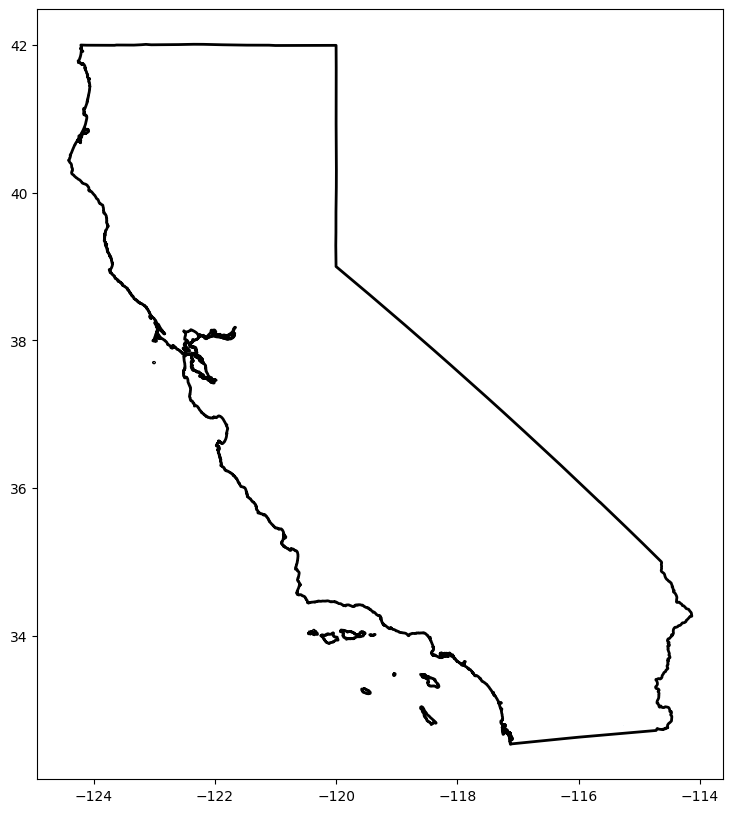

In [187]:
fig, ax = plt.subplots(figsize=(10, 10))
california_gdf.boundary.plot(ax=ax, color='black', linewidth=2)
cali_power_lines.iloc[0:2].plot(ax=ax)
plt.show();

In [203]:
!explorer.exe .